In [18]:
import numpy as np
import pandas as pd
import pickle
from scipy import integrate, signal
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from toy_models import *
%matplotlib widget

# Quantify bif point

In [19]:
bifurcation = []

for i in range(20,50,5):
    with open(f'k50.0_t{i}_simpl.pkl', 'rb') as f:
        params_ksmall, res_ksmall = pickle.load(f)
        
    x_limit = i # check if reasonable
    y_threshold_initial = 1.0
    y_threshold = 10.0

    upper_target_trajectories = []
    lower_target_trajectories = []

    for r in res_ksmall:
        # Check if the trajectory goes straight at the beginning
        if np.all(np.abs(r.y[1][r.y[0] < x_limit]) < y_threshold_initial):
            # If it does, check if the trajectory reaches the upper target
            if r.y[1][-1] > y_threshold:
                upper_target_trajectories.append(r)
            # Check if the trajectory reaches the lower target
            elif r.y[1][-1] < -y_threshold:
                lower_target_trajectories.append(r)

    # print(f'Number of upper target trajectories: {len(upper_target_trajectories)}')
    # print(f'Number of lower target trajectories: {len(lower_target_trajectories)}')

    # Lists to store the y values for each group
    y_values_upper = []
    y_values_lower = []

    # Collect y values for the upper group
    for r in upper_target_trajectories:
        y_values_upper.append(r.y[1][:790])

    # Calculate average y values for the upper group
    avg_y_upper = np.mean(y_values_upper, axis=0)

    # Collect y values for the lower group
    for r in lower_target_trajectories:
        y_values_lower.append(r.y[1][:790])

    # Calculate average y values for the lower group
    avg_y_lower = np.mean(y_values_lower, axis=0)

    # Find the t value where the two averages intersect
    t_intersection = np.where(np.isclose(avg_y_upper, avg_y_lower, atol=0.1))[0]
    #select value greater than 1000
    t_intersection = t_intersection[t_intersection > 200]

    x_up_intersections = []
    x_low_intersections = []

    for r1 in upper_target_trajectories:
        for t in t_intersection:
            x_up_intersections.append(r1.y[0][t])
    
    for r2 in lower_target_trajectories:
        for t in t_intersection:
            x_low_intersections.append(r2.y[0][t])

    # concatenate x_up_intersections and x_low_intersections
    x_inters = np.concatenate((x_up_intersections, x_low_intersections))

    x_min = np.min(x_inters)
    x_max = np.max(x_inters)
    # print(f'x_inters: {x_inters}')
    # Calculate the average and std of the x values at the intersection
    x_intersection = np.mean(x_inters)
    x_intersection_std = np.std(x_inters)

    bifurcation.append([i, x_intersection, x_min, x_max, x_intersection_std])


In [20]:
bifurcation_tdep = []

for i in range(20,50,5):

    # Load the results from the pickle file
    with open(f'k50.0_t{i}.pkl', 'rb') as f:
        params_ksmall, res_ksmall = pickle.load(f)
        
        x_limit = i # check if reasonable
        y_threshold_initial = 1.0
        y_threshold = 10.0

        upper_target_trajectories = []
        lower_target_trajectories = []

        for r in res_ksmall:
            # Check if the trajectory goes straight at the beginning
            if np.all(np.abs(r.y[1][r.y[0] < x_limit]) < y_threshold_initial):
                # If it does, check if the trajectory reaches the upper target
                if r.y[1][-1] > y_threshold:
                    upper_target_trajectories.append(r)
                # Check if the trajectory reaches the lower target
                elif r.y[1][-1] < -y_threshold:
                    lower_target_trajectories.append(r)

        # print(f'Number of upper target trajectories: {len(upper_target_trajectories)}')
        # print(f'Number of lower target trajectories: {len(lower_target_trajectories)}')

        # Lists to store the y values for each group
        y_values_upper = []
        y_values_lower = []

        print(len(upper_target_trajectories[0].y[1]))
        # Collect y values for the upper group
        for r in upper_target_trajectories:
            y_values_upper.append(r.y[1][:1000])

        # Calculate average y values for the upper group
        avg_y_upper = np.mean(y_values_upper, axis=0)

        # Collect y values for the lower group
        for r in lower_target_trajectories:
            y_values_lower.append(r.y[1][:1000])

        # Calculate average y values for the lower group
        avg_y_lower = np.mean(y_values_lower, axis=0)

        # Find the t value where the two averages intersect
        t_intersection = np.where(np.isclose(avg_y_upper, avg_y_lower, atol=0.1))[0]
        print(t_intersection)
        #select value greater than 1000
        t_intersection = t_intersection[t_intersection > 200]

        x_up_intersections = []
        x_low_intersections = []

        for r1 in upper_target_trajectories:
            for t in t_intersection:
                x_up_intersections.append(r1.y[0][t])

        for r2 in lower_target_trajectories:
            for t in t_intersection:
                x_low_intersections.append(r2.y[0][t])

        # concatenate x_up_intersections and x_low_intersections
        x_inters = np.concatenate((x_up_intersections, x_low_intersections))

        x_min = np.min(x_inters)
        x_max = np.max(x_inters)
        # print(f'x_inters: {x_inters}')
        # Calculate the average and std of the x values at the intersection
        x_intersection = np.mean(x_inters)
        x_intersection_std = np.std(x_inters)

        bifurcation_tdep.append([i, x_intersection, x_min, x_max, x_intersection_std])

1000
[  0   1   2   3   4   5 422 423 424 425 426 427 428 429]
1000
[  0   1   2   3   4   5 502 503 504 505 506 507 508 509]
1000
[  0   1   2   3   4 559 560 561 562 563 564 565]
1000
[  0   1   2   3   4 598 599 600 601 602 603 604]
1000
[  0   1   2   3   4 629 630 631 632 633 634 635 636]
1000
[  0   1   2   3   4 655 656 657 658 659 660 661]


In [21]:
bifurcation_tdep

[[20,
  42.58124636698546,
  42.22254531515686,
  42.93498836469579,
  0.2278331226813362],
 [25,
  50.58933126116195,
  50.21775821849191,
  50.94426025730432,
  0.22776918401179294],
 [30,
  56.240508685731974,
  55.927194606155204,
  56.548262965416235,
  0.19834426282567516],
 [35,
  60.14719270792705,
  59.83122738001006,
  60.4530434170706,
  0.19862712114495834],
 [40,
  63.29985848574688,
  62.9374975977888,
  63.654798630966,
  0.22740318917656455],
 [45,
  65.85217504129974,
  65.53358174400665,
  66.15827026734995,
  0.19858314149389675]]

In [22]:
# bifurcation
tar_x = params_ksmall[5]
tar_y = params_ksmall[6]

# convert bifurcatin x to angle
bifurcation_angle = []
for i in range(len(bifurcation)):
    bifurcation_angle.append([bifurcation[i][0],
                              np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][1]))),
                              abs(np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][1]))) - np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][2])))),
                              abs(np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][1]))) - np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][3])))),
                              np.degrees(bifurcation[i][4]/(tar_x))])

# convert bifurcatin x to angle
bifurcation_angle_tdep = []
for i in range(len(bifurcation_tdep)):
    bifurcation_angle_tdep.append([bifurcation_tdep[i][0],
                              np.degrees(np.arctan(tar_y/(tar_x-bifurcation_tdep[i][1]))),
                              abs(np.degrees(np.arctan(tar_y/(tar_x-bifurcation_tdep[i][1]))) - np.degrees(np.arctan(tar_y/(tar_x-bifurcation_tdep[i][2])))),
                              abs(np.degrees(np.arctan(tar_y/(tar_x-bifurcation_tdep[i][1]))) - np.degrees(np.arctan(tar_y/(tar_x-bifurcation_tdep[i][3])))),
                              np.degrees(bifurcation_tdep[i][2]/(tar_x))])

In [23]:
bifurcation_angle_tdep

[[20,
  20.99266288301757,
  0.1882467116997013,
  0.1888559521121458,
  30.70616624740826],
 [25,
  26.22952552253551,
  0.2962126358605346,
  0.28887085647475175,
  36.520650778379924],
 [30,
  31.641693645780155,
  0.3520869134316875,
  0.352813522501517,
  40.6728140738423],
 [35,
  36.699889064505555,
  0.46040547835759327,
  0.45532778045785705,
  43.512005280685166],
 [40,
  41.896252819221054,
  0.6579028123814368,
  0.6611820789827192,
  45.77102706642879],
 [45,
  47.04839144265252,
  0.6959483913504698,
  0.6838103020422182,
  47.659018204599484]]

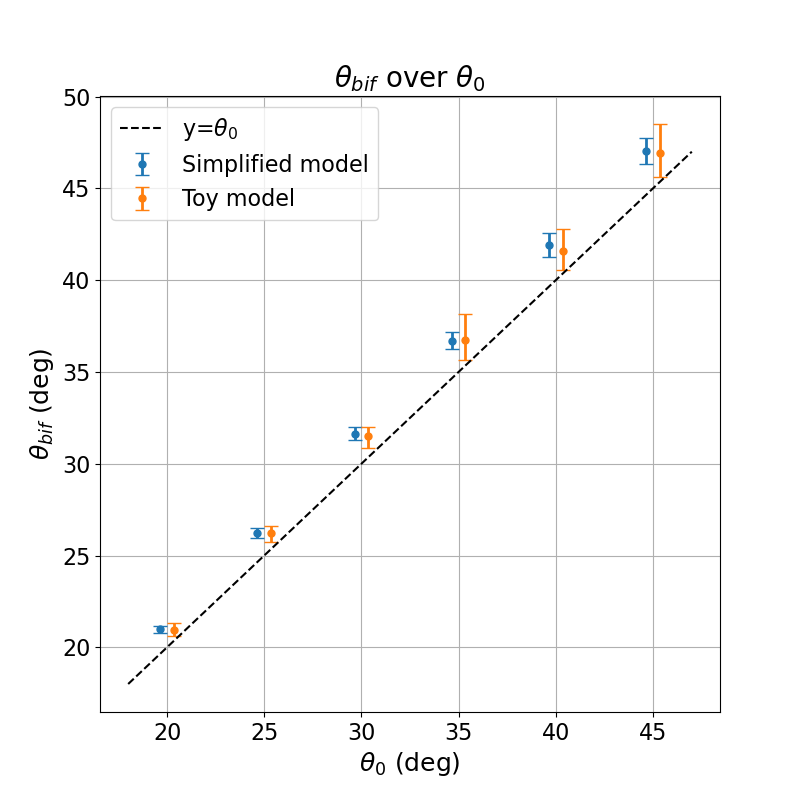

In [41]:
# plot bifurcation angle
fig, ax = plt.subplots(figsize=(8,8))

offset = 0.35

# ax.errorbar([i[0] for i in bifurcation_angle_tdep], [i[1] for i in bifurcation_angle_tdep], yerr=[i[2] for i in bifurcation_angle_tdep], fmt='.', capsize=3, color='black')
ax.errorbar([i[0]-offset for i in bifurcation_angle_tdep], [i[1] for i in bifurcation_angle_tdep], yerr=[[i[2] for i in bifurcation_angle_tdep],[i[3] for i in bifurcation_angle_tdep]],
            fmt='.', markersize=10, capsize=5, elinewidth=2,  color='C0', label='Simplified model')
ax.errorbar([i[0]+offset for i in bifurcation_angle], [i[1] for i in bifurcation_angle], yerr=[[i[2] for i in bifurcation_angle],[i[3] for i in bifurcation_angle]],
            fmt='.', markersize=10, capsize=5, elinewidth=2, color='C1', label='Toy model')
ax.plot([18]+[i[0] for i in bifurcation_angle]+[47], [18]+[i[0] for i in bifurcation_angle]+[47], color='black', linestyle='--', label=r'y=$\theta_0$')
# (ang_thresh, np.degrees(ang_crit), yerr=np.degrees(std), fmt='o', capsize=3, color='black')
plt.xlabel(r'$\theta_0$ (deg)', fontsize=18)
plt.ylabel(r'$\theta_{bif}$ (deg)', fontsize=18)
plt.title(r'$\theta_{bif}$ over $\theta_0$', fontsize=20)
plt.grid(True)
plt.legend(fontsize=16)
# tick size both axes
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

plt.savefig('../img/bifurcation_angle_over_theta0.pdf', bbox_inches='tight')